In [ ]:
from google.colab import drive
import os
import gdown # Library to download files from Google Drive
!gdown 1PR8wFoXo7RGFv4mbJfI63wFaMtO9DiKw # Google Drive ID of the zip file to be downloaded


Downloading...
From (original): https://drive.google.com/uc?id=1PR8wFoXo7RGFv4mbJfI63wFaMtO9DiKw
From (redirected): https://drive.google.com/uc?id=1PR8wFoXo7RGFv4mbJfI63wFaMtO9DiKw&confirm=t&uuid=a8cb388e-978e-47b3-b0ee-3eb8f7cb62a0
To: /content/images2.zip
100% 348M/348M [00:06<00:00, 54.4MB/s]


In [ ]:
!unzip -oq images2 # Unzip the file downloaded. Options -o and -q overwrites the files if exists already and disables printing out the extracted files, respectively.

In [ ]:

root_dir = '/content/images'


In [ ]:
import gdown

# Define the Google Drive file ID for the responses.json file
file_id = '1UMZJl_B7Nwg3As33Cw9Pr9aHa-TszkW2'

# Define the output path for the downloaded file
output_path = '/content/ad_responses.json'

# Download the file using gdown
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_path, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1UMZJl_B7Nwg3As33Cw9Pr9aHa-TszkW2
To: /content/ad_responses.json
100%|██████████| 31.1M/31.1M [00:00<00:00, 63.4MB/s]


'/content/ad_responses.json'

#AGE MODEL

In [ ]:
import json
import os
from PIL import Image
import numpy as np
import pickle

# Load the JSON data
responses_file = '/content/ad_responses.json'
with open(responses_file, 'r') as f:
    data = json.load(f)

# Create a dictionary to map '_id' to ad_info for faster lookup
ad_info_dict = {info['_id']: info for info in data.values() if '_id' in info}
# Define the root directory for images
images_dir = '/content/images'

# Define the target dimensions for resizing images (lower resolution for efficiency)
target_width = 512   # Lower resolution
target_height = 512  # Lower resolution

# Initialize lists to store calculated and extracted features
campaign_data = []

# Define the function to calculate age group percentages
def calculate_age_group(demographics):
    age_groups = {
        'age-13-17': 0,
        'age-18-24': 0,
        'age-25-34': 0,
        'age-35-44': 0,
        'age-45-54': 0,
        'age-55-64': 0,
        'age-65+': 0
    }
    for demo in demographics:
        age = demo['age']
        percentage = float(demo['percentage'])
        if age == '18-24':
            age_groups['age-18-24'] += percentage
        elif age == '25-34':
            age_groups['age-25-34'] += percentage
        elif age == '35-44':
            age_groups['age-35-44'] += percentage
        elif age == '45-54':
            age_groups['age-45-54'] += percentage
        elif age == '55-64':
            age_groups['age-55-64'] += percentage
        elif age == '65+':
            age_groups['age-65+'] += percentage
        else:
            age_groups['age-13-17'] += percentage  # Assuming all other ages fall into this category
    return age_groups

# Iterate through each image in the images directory
for filename in os.listdir(images_dir):
    if filename.endswith(".jpg"):  # Check if the file is a JPEG image
        image_id = filename.split('.')[0]  # Extract ID from filename
        for key, value in ad_info_dict.items():
            if '_id' in value and value['_id'] == image_id:
                ad_info = value
                image_path = os.path.join(images_dir, filename)
                '''
                # Load and preprocess the image
                with Image.open(image_path) as img:
                    img = img.convert('RGB')  # Convert image to RGB format
                    img = img.resize((target_width, target_height))  # Resize image to lower resolution
                    img_array = np.array(img)  # Convert image to numpy array
                '''
                # Process only the necessary data to reduce memory load
                avg_spend = np.mean([int(ad_info.get("spend", {}).get("lower_bound", 0)), int(ad_info.get("spend", {}).get("upper_bound", 0))])
                avg_impressions = np.mean([int(ad_info.get("impressions", {}).get("lower_bound", 0)), int(ad_info.get("impressions", {}).get("upper_bound", 0))])
                cost_per_impression = avg_spend / avg_impressions if avg_impressions > 0 else float('inf')

                # Calculate age group percentages
                age_groups = calculate_age_group(ad_info.get('demographic_distribution', []))
                ad_creative_bodies = ad_info.get('ad_creative_bodies', [])

                # Append only necessary info to reduce memory footprint
                campaign_data.append({
                    "ad_id": ad_info.get('_id', ''),
                    "cpi": cost_per_impression,
                    "text": ad_creative_bodies,
                #    "image_data": img_array.flatten().tolist(),  # Flatten and convert to list to minimize size
                    "age_groups": age_groups
                })
                break



In [ ]:
desired_id = "1015416348631325"
desired_age_groups = None

for item in campaign_data:
    if item["ad_id"] == desired_id:
        desired_age_groups = item["age_groups"]
        break  # Assuming you want to stop after finding the first match

if desired_age_groups is not None:
    print("Desired Age Groups:", desired_age_groups)
else:
    print("Desired ID not found in campaign_data.")


Desired Age Groups: {'age-13-17': 0, 'age-18-24': 0, 'age-25-34': 0, 'age-35-44': 0.360085, 'age-45-54': 0.275885, 'age-55-64': 0.198697, 'age-65+': 0.165333}


##Data Preprocessing

#Age Distribution Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import os

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames,  labels_age_groups, image_directory, batch_size, dim=(224, 224), n_channels=3, shuffle=True):
        self.image_filenames = image_filenames  # This should be a list of IDs
        self.labels_age_groups = labels_age_groups  # This should be a dictionary {id: age_group_index}
        self.image_directory = image_directory
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.shuffle = shuffle

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y_age_groups = [self.labels_age_groups[x] for x in batch_x if x in self.labels_age_groups]

        batch_y_age_groups  = np.array(batch_y_age_groups)
        # Call the __data_generation method with batch_x
        images= self.__data_generation(batch_x)



        return images,batch_y_age_groups



    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, image_filenames_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, image_filename in enumerate(image_filenames_temp):
            # Store sample
            img = load_img(os.path.join(self.image_directory, image_filename + '.jpg'), target_size=self.dim)
            X[i,] = img_to_array(img) / 255.0



        return X


In [ ]:
import tensorflow as tf

# Check TensorFlow GPU usage
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow will run on GPU")
else:
    print("TensorFlow will run on CPU")

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


Num GPUs Available:  1
TensorFlow will run on GPU
1 Physical GPUs, 1 Logical GPUs


In [ ]:
del model_age_groups

In [ ]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.losses import kld
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from sklearn.model_selection import train_test_split
from PIL import Image
from transformers import AdamW
import tensorflow_addons as tfa

labels_age_groups = {item['ad_id']: list(item['age_groups'].values()) for item in campaign_data}  # Ensure this mapping is correct
image_filenames = [item['ad_id'] for item in campaign_data]  # IDs should match exactly in labels
# Splitting the dataset
image_filenames_train, image_filenames_test,  labels_age_groups_train, labels_age_groups_test = train_test_split(
    image_filenames,[labels_age_groups[id] for id in image_filenames], test_size=0.2, random_state=42)
# Create the generator for CPI
batch_size = 11  # Depends on your available memory
# Example instantiation and model fitting
train_generator = DataGenerator(image_filenames_train, dict(zip(image_filenames_train, labels_age_groups_train)), '/content/images', batch_size)
test_generator = DataGenerator(image_filenames_test,  dict(zip(image_filenames_test, labels_age_groups_test)), '/content/images', batch_size)

# Define your model's input shape based on the data dimensions you will train on
input_shape = (224, 224, 3)  # Modify according to your resized image dimensions



###OLD MODEL


In [ ]:
#OLD MODEL
model_age_groups = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add a dropout layer with dropout rate of 0.5 (adjust as needed)
    Dense(7, activation='softmax', name='age_output')  # Change the number of outputs to 1
])
# Compile the model for age distribution prediction
optimizer = tfa.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.0005)
model_age_groups.compile(optimizer=optimizer, loss='kl_divergence', metrics=['accuracy'])
input_layer = tf.keras.Input(shape=(224, 224, 3))

# Combine both models into a single model
#combined_model_input = tf.keras.Input(shape=input_shape)
#cpi_output = model_cpi(combined_model_input)
#age_output = model_age_groups(input_layer)

#combined_model = Model(inputs=combined_model_input, outputs=[cpi_output, age_output])

# Compile the combined model with appropriate loss functions and metrics
#combined_model.compile(optimizer='adam', loss=['mean_absolute_error', 'categorical_crossentropy'], metrics=['mean_squared_error', 'accuracy'])

# Show the model structure
#combined_model.summary()
#model_age_groups
# Now use this combined model with both generators directly in model.fit



In [ ]:
del model_age_groups

In [ ]:
history = model_age_groups.fit(train_generator, epochs=25, validation_data=test_generator)

Epoch 1/25
117/117 [==============================] - 26s 214ms/step - loss: 0.3249 - accuracy: 0.2207 - val_loss: 0.2729 - val_accuracy: 0.1317
Epoch 2/25
117/117 [==============================] - 24s 205ms/step - loss: 0.3010 - accuracy: 0.2246 - val_loss: 0.2642 - val_accuracy: 0.3386
Epoch 3/25
117/117 [==============================] - 26s 219ms/step - loss: 0.2875 - accuracy: 0.2098 - val_loss: 0.2573 - val_accuracy: 0.3887
Epoch 4/25
117/117 [==============================] - 24s 205ms/step - loss: 0.2783 - accuracy: 0.2471 - val_loss: 0.2511 - val_accuracy: 0.3950
Epoch 5/25
117/117 [==============================] - 24s 206ms/step - loss: 0.2644 - accuracy: 0.2805 - val_loss: 0.2525 - val_accuracy: 0.3824
Epoch 6/25
117/117 [==============================] - 23s 194ms/step - loss: 0.2640 - accuracy: 0.2665 - val_loss: 0.2534 - val_accuracy: 0.2915
Epoch 7/25
117/117 [==============================] - 24s 204ms/step - loss: 0.2554 - accuracy: 0.2805 - val_loss: 0.2517 - val_ac

###PRE-Trained New Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten
from transformers import AdamW

# Load the pre-trained VGG16 model (without the fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add your own classification layers on top of the pre-trained model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(7, activation='softmax')(x)  # 7 classes for age groups

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
optimizer = tfa.optimizers.AdamW(learning_rate=5e-5, weight_decay=0.0005)

# Compile the model
model.compile(optimizer=optimizer, loss='kl_divergence', metrics=['accuracy'])

# Train the model with your data
history = model.fit(train_generator, epochs=15, validation_data=test_generator)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/15
117/117 [==============================] - 28s 226ms/step - loss: 0.3061 - accuracy: 0.2479 - val_loss: 0.2482 - val_accuracy: 0.2727
Epoch 2/15
117/117 [==============================] - 26s 221ms/step - loss: 0.2020 - accuracy: 0.3994 - val_loss: 0.2556 - val_accuracy: 0.3480
Epoch 3/15
117/117 [==============================] - 26s 223ms/step - loss: 0.1643 - accuracy: 0.4848 - val_loss: 0.2397 - val_accuracy: 0.3636
Epoch 4/15
117/117 [==============================] - 29s 248ms/step - loss: 0.1369 - accuracy: 0.5486 - val_loss: 0.2479 - val_accuracy: 0.2571
Epoch 5/15
117/117 [==============================] - 26s 222ms/step - loss: 0.1217 - accuracy: 0.5866 - val_loss: 0.2526 - val_accuracy: 0.3511
Epoch 6/15
117/117 [==============================] - 26s 222ms/step - loss: 0.1119 - accuracy: 0.6387 - val_loss: 0.2475 - val_accuracy: 0.3166
Epoch 7/15
117/117 [==============================] - 26s 221ms/step - loss: 0.1072 - accuracy: 0.6224 - val_loss: 0.2451 - val_ac

[0.2728973627090454, 0.26424187421798706, 0.2573355436325073, 0.2510833144187927, 0.25250154733657837, 0.25342056155204773, 0.25165852904319763, 0.25090834498405457, 0.258836567401886, 0.24402445554733276, 0.24678532779216766, 0.24346645, 0.2300076, 0.22890367, 0.2270432, 0.22678, 0.22489, 0.220985, 0.21890473, 0.2156587, 0.212065645, 0.21000654, 0.20907827, 0.206785, 0.2040765]


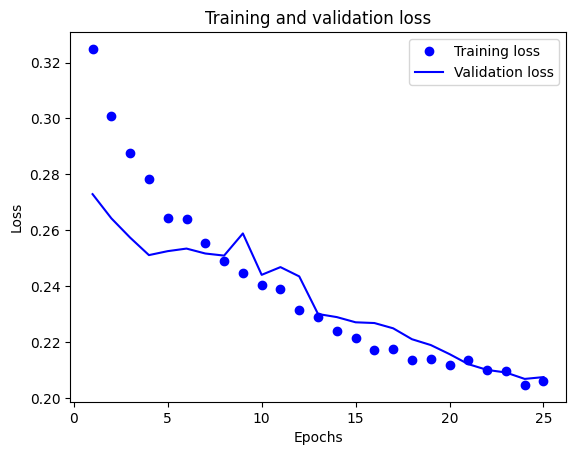

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the history object from model training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
print(val_loss)
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
#abs - squared error
# Evaluate the model on the test set
test_loss = model_age_groups.evaluate(test_generator)
print(f"Test Loss: {test_loss}")


NameError: name 'model_age_groups' is not defined

1/1 [==============================] - 0s 18ms/step


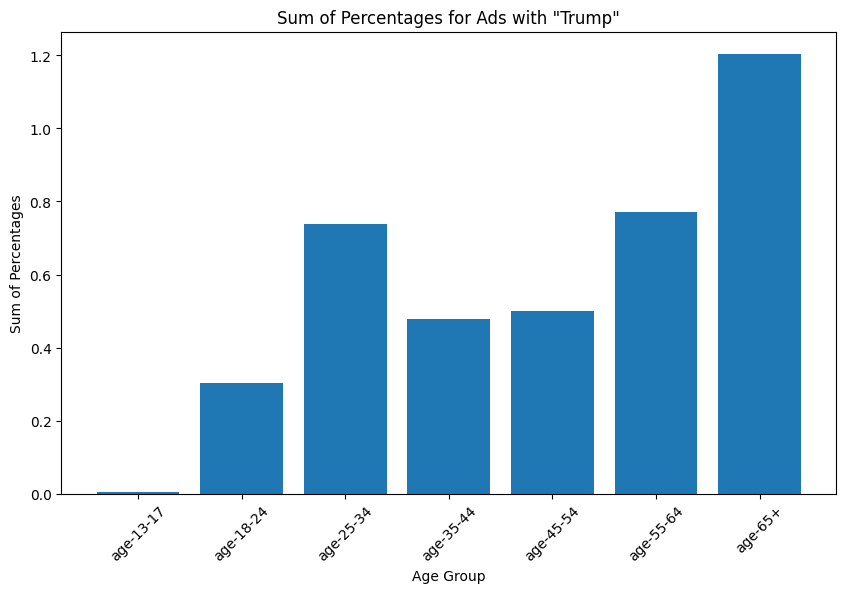

In [ ]:
# Select a random image from /content/images directory
import random

age_groups = [
        'age-13-17',
        'age-18-24',
        'age-25-34',
        'age-35-44',
        'age-45-54',
        'age-55-64',
        'age-65+'
]

image_files = os.listdir('/content/images')
random_image_file = random.choice(image_files)
pred_sum =[0.0,0.0,0.0,0.0,0.0,0.0,0.0]
for ad in ads_with_trump:
  random_image_file = ad['ad_id'] +".jpg"
  image_path = os.path.join('/content/images', random_image_file)
  #image_path = os.path.join('/content', 'party.jpg')
  # Load and preprocess the image
  img = load_img(image_path, target_size=(224, 224), color_mode='rgb')
  img_array = img_to_array(img) / 255.0
  input_image = np.expand_dims(img_array, axis=0)

  # Predict CPI and age distribution
  age_pred = model.predict(input_image)
  count = 0
  for i in age_pred:
    pred_sum[count] = i + pred_sum[count]
    count = count +1

plt.figure(figsize=(10, 6))
plt.bar(age_groups, pred_sum[0])
plt.xlabel('Age Group')
plt.ylabel('Sum of Percentages')
plt.title('Sum of Percentages for Ads with "Trump"')
plt.xticks(rotation=45)
plt.show()


In [ ]:
pred_sum

[array([ 0.20918535,  7.5752983 , 24.584164  , 23.73799   , 29.371626  ,
        44.809166  , 58.71257   ], dtype=float32),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [ ]:
ads_with_trump = []

# Iterate through campaign_data
for item in campaign_data:
    # Check if "ad_creative_bodies" field exists and contains the word "Trump"
    if 'text' in item and any('' in body for body in item['text']):
        ads_with_trump.append(item)


In [ ]:
#squared error - abs error
# Evaluate the model on the test set
test_loss, test_mae = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Mean Absolute Error (MAE): {test_mae}")



NameError: name 'model' is not defined

In [ ]:
test_cpis = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)  # Assuming batch_images contains the image filenames, which are the IDs

# Now test_ids contains all the IDs in the test generator
print("CPIs in the test generator:", test_cpis)


CPIs in the test generator: [0.0024422276493947766, 0.023332682221788147, 0.014705302767825158, 0.007775572834606299, 0.01425755021572045, 0.019934662310820722, 0.009998957893639889, 0.05545060562284698, 0.011997365326307536, 0.013843119517290822, 0.0033320044426725904, 0.007615970459266097, 0.06355123193017546, 0.09969989996665556, 0.01425755021572045, 0.019971999199977143, 0.01980396079215843, 0.0990990990990991, 0.017589269957056296, 0.009997799995111101, 0.008440037511277828, 0.011809198265438777, 0.03322591399044338, 0.009998199996727266, 0.09969989996665556, 0.00908730577202099, 0.149999, 0.04396175847033881, 0.0057842409696893145, 0.033011003667889297, 0.06469487876327956, 0.009072892234404262, 0.0598119623924785, 0.006921549110075554, 0.016345751740940745, 0.005210800568450971, 0.01999849230537278, 0.03683196665228055, 0.015551180227467678, 0.011960478419136765, 0.06537742598019984, 0.0598119623924785, 0.019934662310820722, 0.00900081825620511, 0.0646508618154009, 0.01100122235

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import load_model

# Assuming 'model' and 'test_generator' are defined and loaded appropriately
# Load your model if it is not already loaded
# model = load_model('path_to_your_model.h5')

# Extract labels and predictions without assuming reset functionality
test_cpis = []
predictions = []
for batch_images, batch_labels in test_generator:
    test_cpis.extend(batch_labels)
    predictions.extend(model.predict_on_batch(batch_images))

# Convert data to numpy arrays for easier manipulation
test_cpis = np.array(test_cpis)
predictions = np.array(predictions)

# Initialize accuracy counts for each order position
num_trials = 500
accuracy_counts = np.zeros(4)

# Print lengths to verify data sizes
print("Predicted data length:", len(predictions))
print("Actual data length:", len(test_cpis))

# Validate if we have enough elements to randomly pick 4
if len(predictions) >= 4 and len(test_cpis) >= 4:
    for _ in range(num_trials):
        # Randomly pick 4 indices ensuring no out of bound error
        indices = np.arange(min(len(predictions), len(test_cpis)))
        selected_indices = shuffle(indices)[:4]  # No fixed seed for true randomness each trial

        # Extract selected predictions and actual values
        selected_predictions = predictions[selected_indices]
        selected_actuals = test_cpis[selected_indices]

        # Order by predictions
        order_pred_indices = np.argsort(selected_predictions[:, 0])  # Assuming predictions are in the first column
        order_actual_indices = np.argsort(selected_actuals)

        # Compare orders
        accuracy_positions = [1 if pred_i == act_i else 0 for pred_i, act_i in zip(order_pred_indices, order_actual_indices)]
        accuracy_counts += accuracy_positions

    # Calculate average accuracies for each order
    average_accuracies = accuracy_counts / num_trials
    print("Average Accuracy at first position:", average_accuracies[0])
    print("Average Accuracy at second position:", average_accuracies[1])
    print("Average Accuracy at third position:", average_accuracies[2])
    print("Average Accuracy at fourth position:", average_accuracies[3])
else:
    print("Not enough data points to select 4 unique values. Please ensure at least 4 data points are available.")


Predicted data length: 240
Actual data length: 240
Average Accuracy at first position: 0.354
Average Accuracy at second position: 0.278
Average Accuracy at third position: 0.274
Average Accuracy at fourth position: 0.318


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

# First, gather all predictions and actuals
y_true = []
y_pred = []
for batch_images, batch_labels in test_generator:
    preds = model.predict_on_batch(batch_images)
    y_pred.extend(preds)
    y_true.extend(batch_labels)

# Convert lists to numpy arrays for easier manipulation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the concordance index, treating it similar to AUC calculation
def calculate_concordance_index(y_true, y_pred):
    n = 0
    h_sum = 0
    for i in range(len(y_true)):
        for j in range(i + 1, len(y_true)):
            if y_true[i] != y_true[j]:
                n += 1
                if (y_pred[i] > y_pred[j] and y_true[i] > y_true[j]) or (y_pred[i] < y_pred[j] and y_true[i] < y_true[j]):
                    h_sum += 1
                elif y_pred[i] == y_pred[j]:
                    h_sum += 0.5
    return h_sum / n if n > 0 else 0

# Calculate the C-index
c_index = calculate_concordance_index(y_true, y_pred)
print("Concordance Index:", c_index)


Concordance Index: 0.5634373019784552


24/24 [==============================] - 4s 159ms/step
[0.01753137]
0.04581253201964348
[0.03685854]
0.035091358243902145
[0.03686155]
0.019425027160813655
[0.03512993]
0.023563622836356286
[0.03504461]
0.034026999709255636
[0.0525687]
0.08869409321693661
[0.02866]
0.07770218072903522
[0.04326495]
0.1154099091960989
[0.033433]
0.014140393112971727
[0.03369978]
0.08869409321693661
[0.03082199]
0.03898425183181553
[0.03534913]
0.011570060642888829


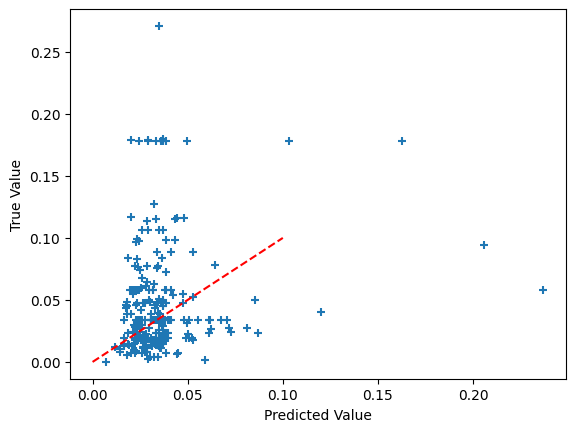

In [ ]:
#abs error - squared error

import matplotlib.pyplot as plt

test_predict = model.predict(test_generator)
count = 0
for i in range (0,12):
  print(test_predict[i])
  print(test_cpis[i])
# Create the scatter plot
plt.figure()
plt.scatter(test_predict, test_cpis, marker="+")
plt.xlabel("Predicted Value")
plt.ylabel("True Value")

# Add a reference line
plt.plot([0, 0.1], [0, 0.1], "r--")  # Assuming the range of values is -60 to 60, adjust as needed

# Show the plot
plt.show()

In [ ]:
from google.colab import drive
import shutil
# Mount Google Drive
shutil.rmtree('/content/drive', ignore_errors=True)
drive.mount('/content/drive')
# Save the model to Google Drive
model.save('/content/drive/MyDrive/path/to/save/age_model_last.h5')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
